In [1]:
# mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import tensorflow as tf
import numpy as np
import re

!pip install pandas
!pip install nltk
!pip install sklearn
!pip install sentencepiece

import pandas as pd
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Input, dot, Activation, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import backend as K
import tensorflow.keras

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
import io
from nltk.tokenize.toktok import ToktokTokenizer
import unicodedata
import sentencepiece as spm


# ignore warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print(tf.__version__)
# gpu
tf.test.is_gpu_available() 

2.2.0-dev20200218


True

# load text file

**this dataset is aleady implemented a SentenceSpace**

In [8]:
num_example = 300000

# create each languages list
def create_lang_list(num_example):
    # load txt file
    lines =  io.open("raw.txt", encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[w for w in l.split('\t')]  for l in lines[:num_example]]

    return zip(*word_pairs)

In [22]:
en, ja = create_lang_list(num_example)

# SentencePiece

In [23]:
ja_sentence = list()
for i in ja:
    ja_sentence.append(i.replace(" ", ""))

In [24]:
ja_text = list()
sp = spm.SentencePieceProcessor()
sp.Load("wiki-ja.model")
for text in ja_sentence:
    ja_text.append(" ".join(sp.EncodeAsPieces(text)).replace("▁", "").strip())

# Text Pre-processing

**Removing accented characters** 

e.g. é → e.

**Expanding Contractions** 

e.g. don't → do not, I'd → I would

**remove special word** 

e.g. remove "123#@"

**Stemming**

 e.g. corder, codes → code

**Lemmatization**

 e.g. better → good

**Tokenize**

 e.g. I am going to restaurant → [[I], [am], [going], [to], [restaurant]]

# Removing accented characters

English might have accent like é but Japanese doesn't have any accent I just create different function to ascii for Japanese and English

In [26]:
# Removing accented characters
def english_unicode_to_ascii(text):
     return ''.join(ascii_text for ascii_text in unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore'))

def japanese_unicode_to_ascii(text):
    return ''.join(ascii_text for ascii_text in unicodedata.normalize('NFKD', text))

In [27]:
# e.g.
japanese_unicode_to_ascii("こんにちは。今日は"), english_unicode_to_ascii("Hello world é ")

('こんにちは。今日は', 'Hello world e ')

# Expanding Contractions
Japanese doesn't have a Contraction words so I just create a one function to expand Contractions for Engish

In [28]:
def expand_constraction(text):

    #  dic for expand constraction words
    constraction_dict= {
        "ain't": "is not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "I'd": "I would",
        "I'd've": "I would have",
        "I'll": "I will",
        "I'll've": "I will have",
        "I'm": "I am",
        "I've": "I have",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }

    #  define match pattern
    #  IGNORECASE → no matter if word is lowercase or uppercase
    #  DOTAIL → . is going to match \n
    contraction_pattern = re.compile('({})'.format('|'.join(constraction_dict.keys())),
                                                  flags=re.IGNORECASE | re.DOTALL)
    #  expand words
    def expand_match(constraction):
        # get constraction word
        match = constraction.group(0)
        first_char = match[0]
        #  get expand word from constraction dict
        expand_constraction = constraction_dict.get(match)\
                                                    if constraction_dict.get(match) \
                                                    else constraction_dict.get(match.lower())
        
        # create expand constraction
        expand_constraction = first_char + expand_constraction[1:]
        return expand_constraction
    
    expanded_text = contraction_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [29]:
# e.g.
expand_constraction("you're good I'd like to go he's she's")

'you are good I would like to go he is she is'

# remove special characters and create space between word and punctuation

replacing everything with space except(a-z, A-Z, "?", "!", "-", "ー", "Kanji", "Katakana", "Hiragana") 
create space between word and punctuation (? ! )

In [30]:
def replace_special_character_to_space(text):
    pattern = r"[^a-zA-Z\u3041-\u309F\u30A1-\u30FF\uFF66-\uFF9F\u4E00-\u9FD0\u309B\u3099\uFF9E\u309C\u309A\uFF9F?!\s、。.,]+"
    text = re.sub(pattern, '', text).rstrip().strip()
    text = text.replace("・" , "")

    text = re.sub(r"([?!.,。、])", r" \1", text)
    text = text.lower()

    return text

In [31]:
# e.g.
replace_special_character_to_space("hello, . #@…123world. I've-------/"), replace_special_character_to_space("こん・にちは。・いい 天、気。カ")

('hello ,  . world . ive', 'こんにちは 。いい 天 、気 。カ')

# Stemming and Lemmatization
I will do stemming only english which can create a base form of a word from a given word. Japanese language doesn't need a stemming

In [32]:
def stemmer_word(text):
    ps = nltk.stem.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [33]:
# e.g.
stemmer_word("hello world she has cat but he had dogs he is went to traveling")

'hello world she ha cat but he had dog he is went to travel'

# Normalize each word

In [34]:
def normalize_english(english_text, japanese_text):
    
    input_value = ()
    target_value = ()
    
    for en_text, ja_text in zip(english_text, japanese_text):
        
        # normalize English
        en_text = english_unicode_to_ascii(en_text)
        en_text = expand_constraction(en_text)
        en_text = replace_special_character_to_space(en_text)

        # input value doesn't need  a START and END sentence  
        input_value += (en_text, )

        # normalize Japanese
        ja_text = japanese_unicode_to_ascii(ja_text)
        ja_text = replace_special_character_to_space(ja_text)

        # add StTART and END sentence
        ja_text = "START_ " + ja_text + " _END"
        
        target_value += (ja_text, )

    return input_value, target_value

# get clean text data

In [35]:
# get normalize text data
input_value, target_value = normalize_english(en, ja_text)

# convert to Series
x = pd.Series(input_value) 
y = pd.Series(target_value)

In [36]:
pd.DataFrame({"input": x, "target": y}).head(20)

,input,target
0,"you are back , are not you , harold ?",START_ あなた は 戻った の ね ハロルド ? _END
1,my opponent is shark .,START_ 俺 の 相手 は シャー ク だ 。 _END
2,this is one thing in exchange for another .,START_ 引き 換え だ ある 事 とある 物の _END
3,"yeah , i am fine .",START_ もう いい よ ご ち そう さま う うん _END
4,do not come to the office anymore . do not cal...,START_ もう 会社 には 来 ない で くれ 電話 も する な _END
5,looks beautiful .,START_ きれい だ 。 _END
6,"get him out of here , because i will fucking k...",START_ 連れ て 行 け 殺し そう だ わ かった か ? _END
7,you killed him !,START_ 殺 した のか ! _END
8,"okay , then who ?",START_ わ ぁ ! いつも すみ ません 。 いい の よ 。 _END
9,it seems a former employee . . .,START_ カンパニー の元 社員 が _END


In [37]:
# get unique vocab

# input value 
all_eng = set()
for input_lang in x:
    for word in input_lang.split():
        if word not in all_eng:
            all_eng.add(word)

# target value
all_ja = set()
for target_lang in y:
    for word in target_lang.split():
        if word not in all_ja:
            all_ja.add(word)

print("unique vocab %d" % len(all_eng))
print("unique vocab %d" %len(all_ja))

unique vocab 54716
unique vocab 26497


english length: 67
japanese length: 86


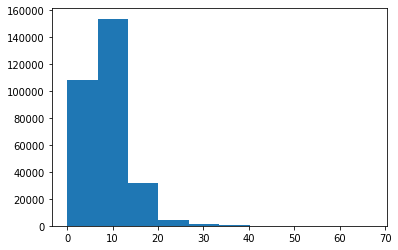

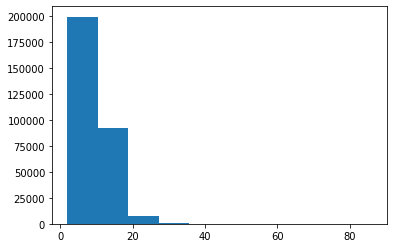

In [38]:
# max length of input sentense and target sentense
english_len = [len(i.split()) for i in x]

japanese_len = [len(i.split()) for i in y]

plt.figure()
plt.hist(english_len)

plt.figure()
plt.hist(japanese_len)

# print max length
print("english length:", max(english_len))
print("japanese length:", max(japanese_len))
max_len_input =  max(english_len)
max_len_target =  max(japanese_len)

In [39]:
input_word = list(all_eng)
target_word = list(all_ja)

num_encoder_tokens = len(all_eng)
num_decoder_tokens = len(all_ja)
num_encoder_tokens, num_decoder_tokens

(54716, 26497)

In [40]:
num_decoder_tokens += 1
num_encoder_tokens += 1

In [41]:
def create_token(token_index_dic, index_token_dic, words):
    for i, word in enumerate(words):
        token_index_dic[word] = i+1
        index_token_dic[i+1] = word
    return token_index_dic, index_token_dic

input_token_index = dict()
target_token_index = dict()
reverse_input_word = dict()
reverse_target_char = dict()

input_token_index, reverse_input_word = create_token(input_token_index, reverse_input_word, input_word)
target_token_index, reverse_target_char = create_token(target_token_index, reverse_target_char, target_word)

In [42]:
start_word = target_token_index["START_"]

# Create train dataset

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=1)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test , test_size=0.5, random_state=1)

In [44]:
X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((210000,), (45000,), (45000,), (210000,), (45000,), (45000,))

# Create generater¶

In [45]:
# create a batch of data
def generate_batch(X, Y, batch_size):
    while True:
        assert len(X) == len(Y)
        for i in range(0, len(X), batch_size):
            # initialize input and target data
            encoder_input_data = np.zeros((batch_size, max_len_input), dtype="float32")
            decoder_input_data = np.zeros((batch_size, max_len_target), dtype="float32")
            decoder_target_data = np.zeros((batch_size, max_len_target, num_decoder_tokens), dtype="float32")
            for j, (input_text, target_text) in enumerate(zip(X[i: i+batch_size], Y[i: i+batch_size])):
                    # create enocder input dataset
                    for t, word in enumerate(input_text.split()):
                        encoder_input_data[j, t] = input_token_index[word]
                    # create decoder input dataset
                    for t, word in enumerate(target_text.split()):
                        if t < len(target_text.split())-1:
                            decoder_input_data[j, t] = target_token_index[word]
                        # decoder  output is one-hot encoding
                        # doesn't include START sentense
                        # one timestep ahead of input 
                        if t > 0:
                            decoder_target_data[j, t-1, target_token_index[word]] = 1.
                    yield([encoder_input_data, decoder_input_data], decoder_target_data)

# Define for params

In [70]:
# initial hyper parameter
BATCH_SIZE = 64
DROPOUT_RATE = 0.3
units = 1024
INITIAL_RATE = 0.0001

In [60]:
import math

# rate scheduler
def  step_decay(epoch):
    initial_rate = INITIAL_RATE
    drop = 0.5
    epochs_drop = 5

    lrate = initial_rate * math.pow(drop, math.floor((1+epoch) / epochs_drop))

    return lrate

# Build a model

In [65]:
def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [73]:
# build encoder model
encoder_input = Input(shape=(None, ))

# Word2Vec
encoder_embedding = Embedding(input_dim=num_encoder_tokens, output_dim=216)(encoder_input) 

# Dropout
encoder = Dropout(rate=DROPOUT_RATE)(encoder_embedding)

# get enternal state to predict target value
# encode output is going to use for attention
encoder_output, state_h, state_c = LSTM(units, return_sequences=True, return_state=True, dropout=DROPOUT_RATE)(encoder)

encoder_states = [state_h, state_c]

# build decoder model
decoder_input = Input(shape=(None, ))

# Word2Vec
decoder_embedding = Embedding(input_dim=num_decoder_tokens, output_dim=216)
decoder_emb = decoder_embedding(decoder_input)

# Dropout
decoder = Dropout(rate=DROPOUT_RATE)(decoder_emb)

decoder_lstm = LSTM(units, return_sequences=True, return_state=True, dropout=DROPOUT_RATE)
# we don't use return state in the train model
decoder, _, _ = decoder_lstm(decoder, initial_state=encoder_states)

# get attention weight
attention = dot([decoder, encoder_output], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)

context = dot([attention, encoder_output], axes=[2, 1])

decoder_combined_context = tf.keras.layers.concatenate([context, decoder])

output = TimeDistributed(Dense(units, activation="tanh"))(decoder_combined_context)

output = TimeDistributed(Dense(num_decoder_tokens, activation="softmax"))(output)

model = Model(inputs=[encoder_input, decoder_input], outputs=[output])

adam = optimizers.Adam(lr=INITIAL_RATE)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, None, 216)    11818872    input_13[0][0]                   
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, None, 216)    5723568     input_14[0][0]                   
____________________________________________________________________________________________

In [74]:
# create dataset as generater
gen_train = generate_batch(X_train, Y_train, BATCH_SIZE)
gen_test = generate_batch(X_test, Y_test, BATCH_SIZE)
gen_val = generate_batch(X_val, Y_val, BATCH_SIZE)

# caluclate train step
trian_step = math.ceil(len(X_train) / BATCH_SIZE)
test_step = math.ceil(len(X_test) / BATCH_SIZE)
val_step = math.ceil(len(X_val) / BATCH_SIZE)

trian_step, val_step, test_step

(3282, 704, 704)

In [75]:
import datetime

# tensorboard
log_dir ="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# checkpoint
filename = "model.ckpt"
checkpoint = ModelCheckpoint(filename, save_weights_only=True, save_best_only=True, mode='min')

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
#                                                  patience=3, min_lr=lr)

es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# rate scheduler
lrate = LearningRateScheduler(step_decay)

callbacks=[es, tensorboard_callback, checkpoint]

# train model
history = model.fit_generator(generator=gen_train, steps_per_epoch=trian_step, epochs=30,
                    callbacks=callbacks, validation_data=gen_val, validation_steps=val_step)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3282 steps, validate for 704 steps
Epoch 1/30
3282/3282 [==============================] - 2861s 872ms/step - loss: 0.2513 - accuracy: 0.0095 - val_loss: 0.4127 - val_accuracy: 0.0054
Epoch 2/30
3282/3282 [==============================] - 2868s 874ms/step - loss: 0.1991 - accuracy: 0.0193 - val_loss: 0.4028 - val_accuracy: 0.0049
Epoch 3/30
3282/3282 [==============================] - 2867s 873ms/step - loss: 0.1821 - accuracy: 0.0253 - val_loss: 0.4221 - val_accuracy: 0.0044
Epoch 4/30
3282/3282 [==============================] - 2866s 873ms/step - loss: 0.1655 - accuracy: 0.0282 - val_loss: 0.4229 - val_accuracy: 0.0042
Epoch 5/30
3282/3282 [==============================] - 2825s 861ms/step - loss: 0.1558 - accuracy: 0.0302 - val_loss: 0.4169 - val_accuracy: 0.0050
Epoch 6/30
3282/3282 [==============================] - 2824s 860ms/step - loss: 0.1493 - accuracy: 0.0305 - val_loss: 0.4381 - val_accuracy: 0.0050
Epoch 7/30


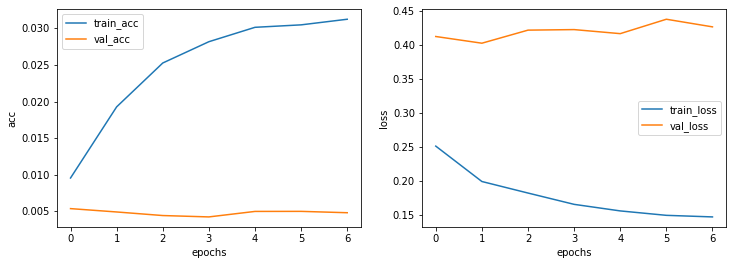

In [76]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history["accuracy"] )
ax1.plot(history.history["val_accuracy"])
ax1.set_xlabel("epochs")
ax1.set_ylabel("acc")
ax1.legend(["train_acc", "val_acc"])

ax2.plot(history.history["loss"])
ax2.plot(history.history["val_loss"])
ax2.set_xlabel("epochs")
ax2.set_ylabel("loss")
ax2.legend(["train_loss", "val_loss"])
plt.show()

In [77]:
# load model
model.load_weights(filename)

# Test

In [78]:
# evalute
score = model.evaluate_generator(gen_test, steps=test_step)
print("loss {}".format(score[0]))
print("acc {}".format(score[1]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
loss 0.41644694415696326
acc 0.004749128594994545


# define testing model

In [79]:
# encoder model
encoder_input = model.input[0] # enocoder input
encoder_output, state_h, state_c = model.layers[6].output # encoder lstm
encoder_state = [state_h, state_c]
encoder_model = Model(encoder_input, encoder_state)
encoder_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_12 (Embedding)     (None, None, 216)         11818872  
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 216)         0         
_________________________________________________________________
lstm_12 (LSTM)               [(None, None, 1024), (Non 5083136   
Total params: 16,902,008
Trainable params: 16,902,008
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.layers

In [82]:
# decoder model
decoder_input = model.input[1] # decoder input
decoder_state_input_h = Input(shape=(units,))
decoder_state_input_c = Input(shape=(units,))
decoder_state_input = [decoder_state_input_h, decoder_state_input_c]
decoder_emb = model.layers[3]
deocder_emb = decoder_emb(decoder_input)
decoder_lstm = model.layers[7] # decoder lstm
decoder_output, dec_state_h, dec_state_c = decoder_lstm(deocder_emb, initial_state=decoder_state_input)
decoder_state = [dec_state_h, dec_state_c]


decoder_dense = model.layers[13]
decoder_output = decoder_dense(decoder_output)

decoder_model = Model([decoder_input] + decoder_state_input, [decoder_output] + decoder_state)
decoder_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, None, 216)    5723568     input_14[0][0]                   
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 1024)]       0                                            
____________________________________________________________________________________________

In [83]:
def decoder_seq(input_seq):
    # encoder the input seq as vector
    state_en = encoder_model.predict(input_seq)
    # generate empty target sequence
    target_seq = np.zeros((1, 1))
    # populate the first character of target seq
    target_seq[0, 0] = start_word

    # loop for batch of sequences
    stop_condition = False
    decoder_sentence = ' '

    while not stop_condition:
        output_token, h, c = decoder_model.predict([target_seq] + state_en)

        sampled_token_index = np.argmax(output_token[0, -1, :])
        sampled_char = reverse_target_char[sampled_token_index]
        decoder_sentence += ' ' + sampled_char

        # stop condition
        if sampled_char == "_END" or len(decoder_sentence) > max_len_input:
            stop_condition = True
        

        # update the target sequence
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # update states
        state_en = [h, c]
    
    return decoder_sentence

In [84]:
test_ge = generate_batch(X_test, Y_test, 1)
k = -1

In [92]:
k+=1
(input_seq, actual_output), _ = next(test_ge)
decoder_sentence = decoder_seq(input_seq)
print("input english %s" % X_test[k:k+1].values[0])
print("actual %s" % Y_test[k:k+1].values[0][6:-4])
print("predict %s" % decoder_sentence[:-4])

from nltk.translate.bleu_score import sentence_bleu

# calculate BLEU score
print('BLEU corpus: %f' % sentence_bleu([Y_test[k:k+1].values[0][6:-4].strip().split(" ")], decoder_sentence[:-4].strip().split(" ")))

input english i do not think they are teaching manners anymore at the schools .
actual  最近の 学校 じゃ 礼儀 も 教 えん 
predict   がなかった に ! は 
BLEU corpus: 0.000000
